# 4: Explore results
Author: Daniel Lusk

Imports and functions

In [1]:
import ast
import json
from pathlib import Path

import geopandas as gpd
import dask_geopandas as dgpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as riox
import seaborn as sns

from geocube.api.core import make_geocube


from utils.geodata import compare_grids, compare_gdf_to_grid, pad_ds
from utils.geodata import read_001_predictions, splot_correlation_old

from utils.visualize import plot_all_trait_obs_pred, plot_pred_cov

%load_ext autoreload
%autoreload 2

/tmp/ipykernel_179588/2328930590.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


## Overall training results

Load the results, map trait IDs to trait names, and remove unneeded columns

In [ ]:
results = pd.read_csv("results/training_results.csv")

# Rename response variable values according to the trait id -> trait name mapping
with open("./trait_id_to_trait_name.json", "r") as f:
    mapping = json.load(f)

# Create a new column called "Trait name" according to the pattern "TRYgapfilled_X{trait_id}_" with {trait_name}
for trait_id, trait in mapping.items():
    results.loc[results["Response variable"].str.contains(trait_id), "Trait name"] = trait

# Rename "Test r-squared" to "Full r-squared"
results = results.rename(columns={"Test r-squared": "Full r-squared"})

run_id_mapping = {
    "2023-09-23_11-44-08": "Original",
    "2023-09-23_12-39-35": "Original + Imputed",
    "2023-09-23_13-30-09": "Log-transformed",
    "2023-09-23_14-19-41": "Log + Imputed",
}

# Only select four most recent run IDs
results = results[results["Run ID"].isin(run_id_mapping.keys())]

# Add new column "Run type" which maps each run ID to its corresponding run type
results["Run type"] = results["Run ID"].map(run_id_mapping)

# Isolate "Predictor importance" into its own dataframe (still retaining Run ID and Response variable)
PI = results[["Run ID", "Run type", "Response variable", "Trait name", "Predictor importance", "CV predictor importance"]]

results = results[
    [
        "Run ID",
        "Run type",
        "Response variable",
        "Trait name",
        "N observations",
        "CV nRMSE",
        "CV nRMSE STD",
        "CV r-squared",
        "CV r-squared STD",
        "Full r-squared",
    ]
]

Look at the top ten and bottom ten models from overall results

In [ ]:
results.sort_values(by=["CV r-squared"], ascending=False).head(10)

In [ ]:
results.sort_values(by=["CV r-squared"], ascending=True).head(10)

**Some quick takeaways:**
- the sPlot traits resulted in the best models. This is likely due to its smaller sample size and (likely) reduced variance.
- It appears that log-transforming the trait data resulted in models that were unable to be fit to the corresponding predictor variables.

Let's set a CV R^2 threshold of 0.05 to remove these outliers and explore the overall performance of each training suite.

In [ ]:
results = results[results["CV r-squared"] > 0.05]

Plot overall results CV r-squared as box plot

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=1)

fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()

models = ["Original", "Original + Imputed", "Log-transformed", "Log + Imputed"]
metrics = ["CV r-squared", "CV r-squared STD", "CV nRMSE", "Full r-squared"]

for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        ax = axs[i]
        sns.boxplot(x="Run type", y=metric, data=results, order=models, ax=ax)
        # data = results[results["Run ID"] == model][metric]
        # sns.boxplot(data=data, ax=ax)
        ax.set(xlabel="Data treatment", label=metric)
        ax.set_xlabel(ax.get_xlabel(), fontweight='bold')
        ax.set_ylabel(ax.get_ylabel(), fontweight='bold')

plt.show()

After dropping outlier models from the log-transformed suite of models, the log-transformed models appear to perform best in terms of CV R^2 and Overall R^2 and with a generally lower CV nRMSE, but greater variance in its CV R^2 standard deviation. This makes sense, as many of the untransformed traits were already normally distributed, and so log-transforming them would likley result in poorer model fitting.

In general, it appears that there is not a big difference between predictor datasets with missing values and imputed datasets, though the CV R^2 STD does increase slightly for models trained on non-imputed datasets.

**Now let's isolate the best performing models for each trait**

In [ ]:
mapping

In [ ]:
# First filter out rows that contain "imputed" in the Run ID column
results_mvs = results[~results["Run type"].str.contains("Imputed")]

# Next split results into GBIF and sPlot dataframes
results_gbif = results_mvs[results_mvs["Response variable"].str.contains("GBIF")]
results_splot = results_mvs[results_mvs["Response variable"].str.contains("sPlot")]

# Next create empty dataframes (one for GBIF and one for sPlot) with the same column names as the results dataframe
# Then, for each trait, get the row with the highest CV r-squared and append it to the empty dataframe
# This will give us the best model for each trait

best_models_gbif = pd.DataFrame(
    columns=results_gbif.columns.values,
    # index=range(len(mapping)),
)
best_models_splot = pd.DataFrame(
    columns=results_splot.columns.values,
    # index=range(len(mapping)),
)

for i, (_, trait) in enumerate(mapping.items()):
    best_gbif_row = (
        results_gbif[results_gbif["Trait name"].str.contains(trait, regex=False)]
        .sort_values(by=["CV r-squared"], ascending=False)
        .iloc[0]
    )
    best_models_gbif = pd.concat([best_models_gbif, best_gbif_row.to_frame().T])
    
    # The best GBIF run types don't necessarily correspond to the best sPlot run types
    # for the same traits, but for an apples-to-apples comparison we should use the same
    # run types for both datasets
    best_gbif_trait = best_gbif_row["Response variable"].split("GBIF_")[1]

    best_splot_row = (
        results_splot[
            results_splot["Response variable"].str.contains(best_gbif_trait)
        ]
        .sort_values(by=["CV r-squared"], ascending=False)
        .iloc[0]
    )

    best_models_splot = pd.concat([best_models_splot, best_splot_row.to_frame().T])

best_models_gbif = best_models_gbif.sort_values(by=["CV r-squared"], ascending=False)
best_models_splot = best_models_splot.sort_values(by=["CV r-squared"], ascending=False)

In [ ]:
best_models_gbif

In [ ]:
print(best_models_gbif.to_markdown(index=False, floatfmt=".3f"))

In [ ]:
print(best_models_splot.to_markdown(index=False, floatfmt=".3f"))

Figure with scatterplots of CV-predictions vs observed for each of a subset of traits, along with R

In [ ]:
results_dir = Path("results/training")
# Create a list of tuples of Run ID and Response variable for each row in best_models_gbif and best_models_splot
# This will be used to filter out the results dataframes to only include the best model for each trait
gbif_id_rvs = list(
    zip(best_models_gbif["Run ID"], best_models_gbif["Response variable"])
)
splot_id_rvs = list(
    zip(best_models_splot["Run ID"], best_models_splot["Response variable"])
)

gbif_trait_dirs = [Path(results_dir / run_id / rv) for run_id, rv in gbif_id_rvs]
splot_trait_dirs = [Path(results_dir / run_id / rv) for run_id, rv in splot_id_rvs]

In [ ]:
plot_all_trait_obs_pred(gbif_trait_dirs, mapping)

In [ ]:
plot_all_trait_obs_pred(splot_trait_dirs, mapping)

## Crowd-sourced vs sPlotOpen

Figure: Box plot of GBIF and sPlot CV-R2 (y-axis) for each trait (x-axis). I.e. two boxes for each trait, one for GBIF and one for sPlot. Could print RMSE ± STD for each one, too?

In [ ]:
best_models_gbif = best_models_gbif.sort_values(by=["CV r-squared"], ascending=False)
best_models_splot = best_models_splot.sort_values(by=["CV r-squared"], ascending=False)

# For each matching Response variable in best_models_gbif and best_models_splot, plot
# the CV r-squared values as a bar chart, with the corresponding CV r-squared STD representing the error bars

# First, drop the GBIF_ and sPlot_ prefixes from the Response variable column
best_models_gbif["Response variable"] = best_models_gbif["Response variable"].str.replace("GBIF_", "")
best_models_splot["Response variable"] = best_models_splot["Response variable"].str.replace("sPlot_", "")

# Then, merge the two dataframes on Response variable
best_models_gbif_splot = pd.merge(best_models_gbif, best_models_splot, on="Response variable", suffixes=("_gbif", "_splot"))

import pandas as pd
import matplotlib.pyplot as plt

# set the plot style
plt.style.use("ggplot")

# set the figure size
plt.figure(figsize=(25, 9))

# set the x-axis labels
x_labels = best_models_gbif_splot["Trait name_gbif"]

# set the bar width
bar_width = 0.35

# set the x-axis positions
x_pos = [i for i in range(len(x_labels))]

# plot the GBIF CV r-squared values as bars
gbif_r2 = best_models_gbif_splot["CV r-squared_gbif"]
gbif_std = best_models_gbif_splot["CV r-squared STD_gbif"]
plt.bar(x_pos, gbif_r2, width=bar_width, yerr=gbif_std, label="GBIF")

# plot the sPlot CV r-squared values as bars
splot_r2 = best_models_gbif_splot["CV r-squared_splot"]
splot_std = best_models_gbif_splot["CV r-squared STD_splot"]
plt.bar([i + bar_width for i in x_pos], splot_r2, width=bar_width, yerr=splot_std, label="sPlot")

# set the x-axis labels and title
plt.xlabel("Response variable")
# Y label as "CV R2" with the 2 in R2 in superscript
plt.ylabel("CV R$^2$")
# plt.title("CV R$^2$ values for GBIF and sPlot")

# set the x-axis tick positions and labels
plt.xticks([i + bar_width / 2 for i in x_pos], x_labels, rotation=90)

# add a legend
plt.legend()

# show the plot
plt.show()


Table (or bar chart) showing global cover % for GBIF vs sPlotOpen traits (should include CV R2 for each model, too, since GBIF generally has lower R2.

In [ ]:
predict_name = "MOD09GA.061_ISRIC_soil_WC_BIO_VODCA_0.5_deg_nan-strat=any_thr=0.5"
predicted_traits = list(Path(f"results/predictions/{predict_name}/").glob("*"))
# select_traits = [trait.name for trait in select_traits]

# replace trait id with trait name from mapping
# for i, trait in enumerate(select_traits):
#     trait_id = trait.split("_")[1].split("X")[-1]
#     trait_name = mapping[trait_id]
#     select_traits[i] = trait.replace(f"X{trait_id}", trait_name)

aoa_df = pd.DataFrame(
    columns=["Response variable", "GBIF AOA", "sPlot AOA", "Pct change"],
    index=range(len(predicted_traits)),
)

gbif_predictions = []
splot_predictions = []

for i, trait in enumerate(predicted_traits):
    if not trait.is_dir():
        continue
    gbif_trait_df = gpd.read_parquet(trait / f"GBIF/{predict_name}_predict.parq")
    splot_trait_df = gpd.read_parquet(trait / f"sPlot/{predict_name}_predict.parq")

    gbif_predictions.append(gbif_trait_df)
    splot_predictions.append(splot_trait_df)
    
    # For each trait, add a new row to aoa_df with the response variable, GBIF AOA, and sPlot AOA

    gbif_aoa = gbif_trait_df["AOA"].sum() / gbif_trait_df["AOA"].count()
    splot_aoa = splot_trait_df["AOA"].sum() / splot_trait_df["AOA"].count()

    # map trait id to trait name
    trait_id = trait.name.split("_")[1].split("X")[-1]
    trait_name = mapping[trait_id]

    new_row = {
        "Response variable": trait_name,
        "GBIF AOA": gbif_aoa,
        "sPlot AOA": splot_aoa,
        "Pct change": (gbif_aoa - splot_aoa) * 100,
    }

    aoa_df.iloc[i] = new_row

aoa_df = aoa_df.dropna().reset_index(drop=True)

In [ ]:
print(aoa_df.to_markdown(index=False, floatfmt=".2f"))

In [ ]:
aoa_df["Pct change"].mean()

## Global trait maps visualization

Figure of global trait maps for selected traits with two columns—left column containing trait predictions masked by AoA, right column containing trait prediction CoV (also masked by AoA?)

First, back-transform trait values predicted by models trained in log-space.

In [ ]:
for i, (gbif, splot) in enumerate(zip(gbif_predictions, splot_predictions)):
    if gbif.columns[0].endswith("_ln"):
        # back-transform columns 0 and 4
        gbif.iloc[:, 0] = np.exp(gbif.iloc[:, 0])
        gbif.iloc[:, 4] = np.exp(gbif.iloc[:, 4])
    
    if splot.columns[0].endswith("_ln"):
        # back-transform columns 0 and 4
        splot.iloc[:, 0] = np.exp(splot.iloc[:, 0])
        splot.iloc[:, 4] = np.exp(splot.iloc[:, 4])
    
    # rename columns 0 and 4 by replacing "_ln" with nothing
    gbif = gbif.rename(columns={gbif.columns[0]: gbif.columns[0].replace("_ln", "")})
    gbif = gbif.rename(columns={gbif.columns[4]: gbif.columns[4].replace("_ln", "")})

    splot = splot.rename(columns={splot.columns[0]: splot.columns[0].replace("_ln", "")})
    splot = splot.rename(columns={splot.columns[4]: splot.columns[4].replace("_ln", "")})

    gbif_predictions[i] = gbif
    splot_predictions[i] = splot

In [ ]:
for i, (gbif, splot) in enumerate(zip(gbif_predictions, splot_predictions)):
    gbif_predictions[i] = make_geocube(vector_data=gbif, resolution=(-0.5, 0.5))
    gbif_predictions[i] = pad_ds(gbif_predictions[i])

    splot_predictions[i] = make_geocube(vector_data=splot, resolution=(-0.5, 0.5))
    splot_predictions[i] = pad_ds(splot_predictions[i])

In [ ]:
plot_pred_cov(gbif_predictions)

Figure (appendix): All remaining global trait maps with > R2-THRESHOLD

## Feature importances

Filter models with a CV r^2 below 0.2

In [ ]:
pi_gbif = PI.loc[best_models_gbif[best_models_gbif["CV r-squared"] > 0.2].index]
pi_splot = PI.loc[best_models_splot[best_models_splot["CV r-squared"] > 0.2].index]

In [ ]:
def ds_importance(PIs):
    
    PIs = ast.literal_eval(PIs)

    ds_keys = {
        "MODIS": ["sur_refl"],
        "WorldClim": ["wc2.1"],
        "Soil": ["0-5cm", "0-30cm", "5-15cm", "15-30cm", "30-60cm", "60-100cm", "100-200cm"],
        "VODCA": ["C_2", "Ku_2", "X_2"]
    }

    # Get the average and standard deviation of the predictor importance values for each dataset
    PIs = {
        k: [np.mean(v), np.std(v)] for k, v in PIs.items()
    }

    ds_importance = {}

    for ds, keys in ds_keys.items():
        
        for feature, imp in PIs.items():
            for key in keys:
                if key in feature:
                    if ds not in ds_importance:
                        ds_importance[ds] = []
                    ds_importance[ds].append(imp)
    
    return ds_importance


In [ ]:
# Get DS importance for each response variable in PI_orig_gbif and PI_orig_splot
pi_gbif["DS importance"] = pi_gbif["CV predictor importance"].apply(ds_importance)
pi_splot["DS importance"] = pi_splot["CV predictor importance"].apply(ds_importance)

Figure: box and whisker plot of predictor datasets (x-axis) and their average importances across all traits for which models had a > R2-THRESHOLD score.

In [ ]:
# create a list of dataframes for each dataset for GBIF
dfs_gbif = []
for ds in pi_gbif["DS importance"].iloc[0].keys():
    df = pd.DataFrame(
        {
            "Dataset": ds,
            "Mean importance": [
                np.asarray(imp[ds])[:, 0].mean() for imp in pi_gbif["DS importance"]
            ],
            "STD importance": [
                np.asarray(imp[ds])[:, 1].mean() for imp in pi_gbif["DS importance"]
            ],
        }
    )
    dfs_gbif.append(df)

# concatenate the dataframes into a single dataframe for GBIF
df_gbif = pd.concat(dfs_gbif)

# create a list of dataframes for each dataset for sPlot
dfs_splot = []
for ds in pi_splot["DS importance"].iloc[0].keys():
    df = pd.DataFrame(
        {
            "Dataset": ds,
            "Mean importance": [
                np.asarray(imp[ds])[:, 0].mean() for imp in pi_splot["DS importance"]
            ],
            "STD importance": [
                np.asarray(imp[ds])[:, 1].mean() for imp in pi_splot["DS importance"]
            ],
        }
    )
    dfs_splot.append(df)

# concatenate the dataframes into a single dataframe for sPlot
df_splot = pd.concat(dfs_splot)

# set the plot style
sns.set_theme()
# sns.set_style("whitegrid")

# create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# plot the GBIF boxplot
sns.boxplot(x="Dataset", y="Mean importance", data=df_gbif, ax=axs[0])
axs[0].set_xlabel("Dataset")
axs[0].set_ylabel("Mean importance")
axs[0].set_title("Predictor dataset importances for GBIF\nmodels with >0.2 CV r-squared")

# plot the sPlot boxplot
sns.boxplot(x="Dataset", y="Mean importance", data=df_splot, ax=axs[1])
axs[1].set_xlabel("Dataset")
axs[1].set_ylabel("")
axs[1].set_title("Predictor dataset importances for sPlot\nmodels with >0.2 CV r-squared")

# adjust the layout and spacing
plt.tight_layout()

# show the plot
plt.show()

Figure (appendix): Feature importance of individual predictors across all traits for which models had a > R2-THRESHOLD score.

## Comparison of GBIF (and other products) with sPlotOpen grids

Build the dataframe

In [107]:
from pathlib import Path

prod_05_fns = Path("data/other-products/all-prods_stacks_sla-nit-nita_05D_2023-12-15").glob("*.nc")
prod_2_fns = Path("data/other-products/all-prods_stacks_sla-nit-nita_2D_2023-12-15").glob("*.nc")

prod_05_deg = [riox.open_rasterio(fn, masked=True) for fn in prod_05_fns]
prod_2_deg = [riox.open_rasterio(fn, masked=True) for fn in prod_2_fns]

trait_product_mapping = {
    50: "_nita_",
    14: "_nit_",
    11: "_sla_",
}

product_names = sorted(set([str(dv) for prod in prod_05_deg for dv in prod.data_vars]))

with open("./trait_mapping.json", "r", encoding="utf-8") as f:
    trait_mapping = json.load(f)

traits = [trait_mapping[str(trait_id)]["short"] for trait_id in trait_product_mapping.keys()]

mi_columns = pd.MultiIndex.from_product(
        [traits, ["2", "0.5", "0.2", "0.01"]]
    )

rows = pd.Index(product_names)
product_df = pd.DataFrame(index=rows, columns=mi_columns)

In [110]:
from utils.geodata import compare_gdfs, ds2gdf, num_to_str

resolutions = ["2", "0.5"]

for res in resolutions:
    if res == "2":
        prod_set = prod_2_deg

    elif res == "0.5":
        prod_set = prod_05_deg

    for i, trait in enumerate(prod_set):
        dv_names = list(trait.data_vars)
        prod_fn = trait[dv_names[0]].encoding["source"]
        for k, v in trait_product_mapping.items():
            if v in prod_fn:
                trait_id = k
                break
        trait_name = trait_mapping[str(trait_id)]["short"]
        # print(trait_name)
        splot = riox.open_rasterio(
            list(
                Path(
                    "GBIF_trait_maps/global_maps/Shrub_Tree_Grass", 
                    f"{num_to_str(float(res))}deg"
                ).glob(f"sPlot*_X{trait_id}_*.grd")
            )[0],
            masked=True,
        ).sel(band=2)
        splot = ds2gdf(splot, f"splot {trait_name}")

        for prod in trait.data_vars:
            gdf = ds2gdf(trait[prod], trait_name)
            corr = compare_gdfs(gdf, splot)
            # print(f"{res}: {corr}")
            product_df.loc[prod, (trait_name, res)] = corr

product_df = product_df.astype(float)
product_df.round(3)

Leaf N per area                 Leaf N                    SLA  \
                         2    0.5 0.2 0.01      2    0.5 0.2 0.01      2   
Bodegom                NaN    NaN NaN  NaN    NaN    NaN NaN  NaN  0.441   
Boonman              0.541  0.481 NaN  NaN  0.060  0.013 NaN  NaN  0.458   
Butler               0.467  0.465 NaN  NaN  0.153  0.174 NaN  NaN  0.226   
Dong                 0.493  0.562 NaN  NaN  0.186  0.161 NaN  NaN  0.320   
Madani                 NaN    NaN NaN  NaN    NaN    NaN NaN  NaN  0.161   
Moreno               0.585  0.520 NaN  NaN  0.149  0.200 NaN  NaN  0.435   
Schiller             0.690  0.588 NaN  NaN  0.436  0.439 NaN  NaN  0.612   
Vallicrosa          -0.006  0.010 NaN  NaN  0.149  0.223 NaN  NaN    NaN   

                            
              0.5 0.2 0.01  
Bodegom     0.451 NaN  NaN  
Boonman     0.504 NaN  NaN  
Butler      0.266 NaN  NaN  
Dong        0.345 NaN  NaN  
Madani      0.009 NaN  NaN  
Moreno      0.433 NaN  NaN  
Schiller    0.599 NaN  NaN  
Vallicrosa    NaN NaN  NaN

#### Now load GBIF and sPlot correlations

See `scripts/splot_correlations.py`

In [104]:
import pandas as pd

%load_ext autoreload
%autoreload 2

corr_table = pd.read_parquet("results/trait_correlations.parquet")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
corr_table

Resolution                     2                 0.5                 0.2  \
Training data               GBIF     sPlot      GBIF     sPlot      GBIF   
Trait PFT                                                                  
X1080 Grass             0.512088  0.714197  0.477290  0.818876  0.433482   
      Shrub-Tree        0.394807  0.633983  0.391408  0.829734  0.366235   
      Shrub-Tree-Grass  0.595198  0.767828  0.567104  0.853300  0.507628   
X11   Grass             0.519403  0.742614  0.773118  0.346305  0.554064   
      Shrub-Tree        0.648613  0.793360  0.780151  0.464470  0.497251   
...                          ...       ...       ...       ...       ...   
X78   Shrub-Tree        0.908601  0.814928  0.763375  0.955979  0.704176   
      Shrub-Tree-Grass  0.834395  0.710908  0.669848  0.956874  0.598353   
X95   Grass             0.378747  0.653122  0.268143  0.828251  0.160021   
      Shrub-Tree        0.587139  0.765184  0.457780  0.881473  0.349268   
      Shrub-Tree-Grass  0.498766  0.713124  0.377413  0.876738  0.247135   

Resolution                            0.01            
Training data              sPlot      GBIF     sPlot  
Trait PFT                                             
X1080 Grass             0.569679  0.364132  0.436590  
      Shrub-Tree        0.577297  0.321324  0.464511  
      Shrub-Tree-Grass  0.641334  0.443440  0.533995  
X11   Grass             0.672648  0.533083  0.571730  
      Shrub-Tree        0.636637  0.369036  0.538141  
...                          ...       ...       ...  
X78   Shrub-Tree        0.800472  0.673362  0.737797  
      Shrub-Tree-Grass  0.736984  0.591523  0.679595  
X95   Grass             0.397111  0.147746  0.295241  
      Shrub-Tree        0.522899  0.322996  0.454080  
      Shrub-Tree-Grass  0.476968  0.200641  0.376395  

[99 rows x 8 columns]

Get only Shrub-Tree-Grass correlations for selected traits

In [113]:
idx = pd.IndexSlice
gbif_splot_corr = corr_table.loc[idx[[f"X{trait_id}" for trait_id in trait_product_mapping.keys()], "Shrub-Tree-Grass"], :]
gbif_splot_corr.index = gbif_splot_corr.index.droplevel(1)
gbif_splot_corr

Resolution            2                 0.5                 0.2            \
Training data      GBIF     sPlot      GBIF     sPlot      GBIF     sPlot   
Trait                                                                       
X50            0.653056  0.850999  0.664851  0.954924  0.599065  0.725797   
X14            0.454139  0.743701  0.724861  0.240542  0.435822  0.619673   
X11            0.595910  0.798599  0.797348  0.407612  0.499793  0.635310   

Resolution         0.01            
Training data      GBIF     sPlot  
Trait                              
X50            0.508222  0.597812  
X14            0.356187  0.490741  
X11            0.426383  0.554600

In [201]:
for row in gbif_splot_corr.iterrows():
    trait_id = row[0].split("X")[-1]
    trait_name = trait_mapping[trait_id]["short"]
    sub_df = row[1].reset_index()
    for sub_row in sub_df.iterrows():
        res = sub_row[1]["Resolution"]
        train_set = sub_row[1]["Training data"]
        corr = sub_row[1][-1]
        product_df.loc[train_set, (trait_name, res)] = corr

In [204]:
product_df.sort_values(by=[("Leaf N per area", "0.5")], ascending=False)

Leaf N per area                                  Leaf N            \
                         2       0.5       0.2      0.01         2       0.5   
sPlot             0.850999  0.954924  0.725797  0.597812  0.743701  0.240542   
GBIF              0.653056  0.664851  0.599065  0.508222  0.454139  0.724861   
Schiller          0.689849  0.588321       NaN       NaN  0.436405  0.438992   
Dong              0.492991  0.561878       NaN       NaN  0.185571  0.161362   
Moreno            0.585379  0.519646       NaN       NaN  0.148687  0.200285   
Boonman           0.540734  0.481172       NaN       NaN  0.059941  0.013427   
Butler            0.467470  0.465114       NaN       NaN  0.152760  0.173820   
Vallicrosa       -0.006161  0.009934       NaN       NaN  0.148699  0.223277   
Bodegom                NaN       NaN       NaN       NaN       NaN       NaN   
Madani                 NaN       NaN       NaN       NaN       NaN       NaN   

                                     SLA                                
                 0.2      0.01         2       0.5       0.2      0.01  
sPlot       0.619673  0.490741  0.798599  0.407612  0.635310  0.554600  
GBIF        0.435822  0.356187  0.595910  0.797348  0.499793  0.426383  
Schiller         NaN       NaN  0.611621  0.599159       NaN       NaN  
Dong             NaN       NaN  0.319620  0.344558       NaN       NaN  
Moreno           NaN       NaN  0.435492  0.433377       NaN       NaN  
Boonman          NaN       NaN  0.458396  0.503725       NaN       NaN  
Butler           NaN       NaN  0.225849  0.265723       NaN       NaN  
Vallicrosa       NaN       NaN       NaN       NaN       NaN       NaN  
Bodegom          NaN       NaN  0.441048  0.451423       NaN       NaN  
Madani           NaN       NaN  0.161248  0.008619       NaN       NaN

Shrub-Tree-Grass

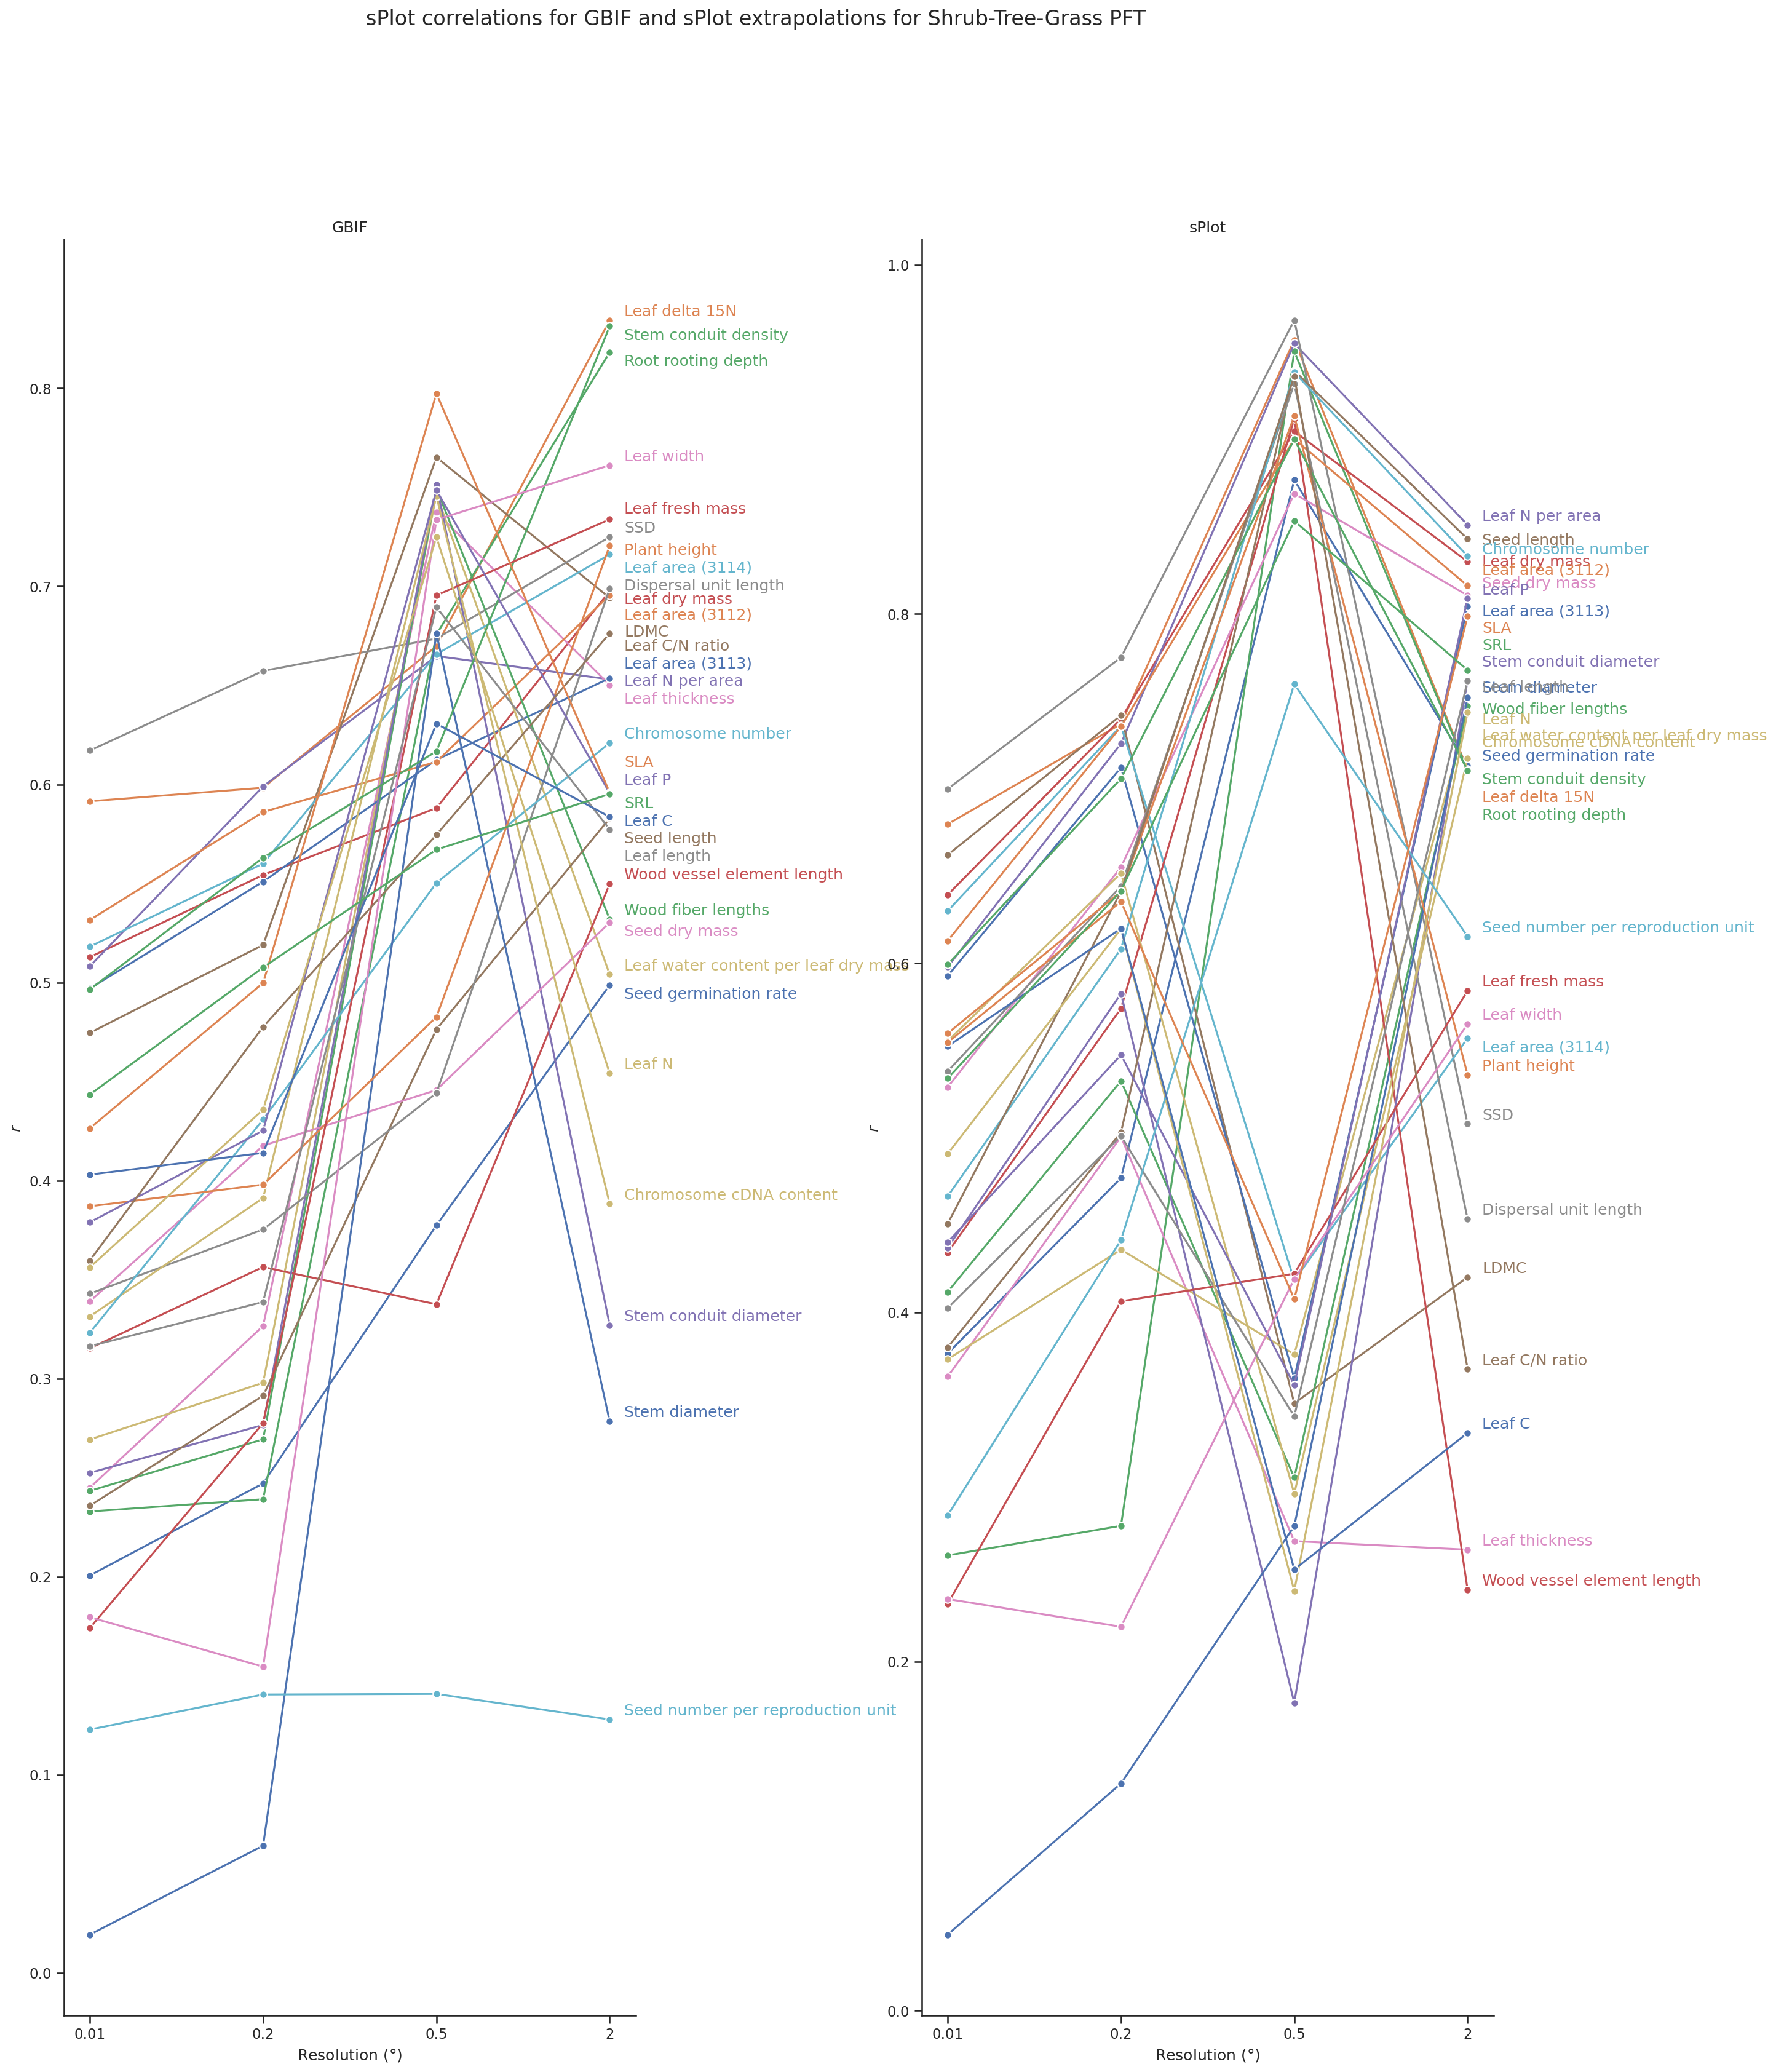

In [72]:
from utils.visualize import plot_splot_correlations


plot_splot_correlations(corr_table, "Shrub-Tree-Grass")